### Импорты


In [1]:
import pandas as pd
import copy

### Класс автобуса

In [29]:
class Bus():
    def __init__(self,busID, free = True, direction = True):
        self.busID = busID
        self.free = free
        self.lunch = False
        #true - forward, false - back
        #Прямо, Обратно, Свободный
        self.direction = direction
        self.first = False
        self.workhr = pd.to_datetime("0:0", format= "%H:%M")

    def change_free(self):
        self.free = not(self.free)
    def change_lunch(self):
        self.lunch = not(self.lunch)

    def change_dir(self):
        self.direction = not(self.direction)
        
    def set_time(self, time):
        self.timefree = time
        
    def first_start(self):
        self.first = True
    def addtime(self, time):
        self.workhr += pd.Timedelta( minutes=time)
    def reset_time(self):
        self.workhr = pd.to_datetime("0:0", format= "%H:%M")
        
class Station():
    def __init__(self, timestart, timestop, start, stop, types = "Рейс"):
        self.timestart = timestart
        self.timestop = timestop
        self.start = start
        self.stop = stop
        self.type = types
    def print_info(self):
        start = self.timestart.strftime("%X")
        stop = self.timestop.strftime("%X")
        return start, stop, self.start, self.stop, self.type
        
    




### Подготовка


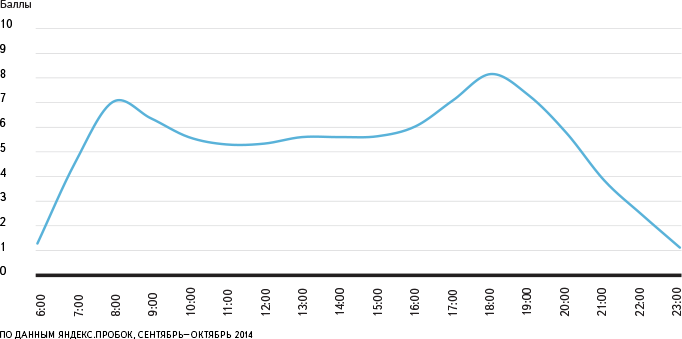

#### Парсер

In [22]:
header = ["time", "countf", "delayf", "countb", "delayb"]
df_timetable = pd.read_excel('606.xlsx',names = header,   usecols="Q:U",skiprows = 25, nrows = 48 )


In [23]:
df_timetable.tail(10)

,time,countf,delayf,countb,delayb
38,22:00,2,16,2,16
39,22:30,2,16,2,16
40,23:00,1,20,2,16
41,23:30,2,20,1,20
42,00:00,1,20,2,20
43,00:30,0,нет рейсов,1,20
44,01:00,0,нет рейсов,0,нет рейсов
45,01:30,0,нет рейсов,0,нет рейсов
46,02:00,0,нет рейсов,0,нет рейсов
47,02:30,0,нет рейсов,0,нет рейсов


In [67]:
df_timetable = pd.read_excel('test.xlsx')


In [24]:
#Переведем время в datetime
df_timetable["time_dt"] = df_timetable["time"].apply(lambda x: pd.to_datetime(x, format= "%H:%M"))
df_timetable.head(10)


,time,countf,delayf,countb,delayb,time_dt
0,03:00,0,нет рейсов,0,нет рейсов,1900-01-01 03:00:00
1,03:30,0,нет рейсов,0,нет рейсов,1900-01-01 03:30:00
2,04:00,0,нет рейсов,0,нет рейсов,1900-01-01 04:00:00
3,04:30,0,нет рейсов,0,нет рейсов,1900-01-01 04:30:00
4,05:00,1,20,0,нет рейсов,1900-01-01 05:00:00
5,05:30,2,20,1,20,1900-01-01 05:30:00
6,06:00,3,9,3,20,1900-01-01 06:00:00
7,06:30,4,9,3,9,1900-01-01 06:30:00
8,07:00,3,8,3,9,1900-01-01 07:00:00
9,07:30,4,8,4,8,1900-01-01 07:30:00


In [25]:
#Заменим нет рейсов на 0
df_timetable.loc[df_timetable["delayf"] == "нет рейсов", "delayf"] = 0
df_timetable.loc[df_timetable["delayb"] == "нет рейсов", "delayb"] = 0
df_timetable.head(2)

,time,countf,delayf,countb,delayb,time_dt
0,03:00,0,0,0,0,1900-01-01 03:00:00
1,03:30,0,0,0,0,1900-01-01 03:30:00


### MainTest


#### Функции:


In [26]:
def addToTT(bus, countbus, dictt, ntime, minute, second, direction, lp = " "):
    stoptime = ntime + pd.Timedelta(minutes = minute, seconds = second)
    if stoptime.day == 2:
            stoptime -= pd.Timedelta(days = 1)
    
    #Костыль
    if direction == True:
        st = Station(ntime, stoptime, "НП","КП") 
    elif direction == False:
        st = Station(ntime, stoptime, "КП","НП") 
    elif direction == "нулевой пробег":
        st = Station(ntime, stoptime, "Парк","НП", "Нулевой пробег") 
    elif direction == "обед":
        st = Station(ntime, stoptime, lp, lp, "Обед") 
    
    
    dictt[bus.busID].append(st)
    banfree = ["нулевой пробег", "обед"]
    if direction not in banfree:
        bus.change_free()
    lastsendf = ntime
    countbus += 1
    return countbus, lastsendf


def changePhase(ntime, df_timetable):
    row = df_timetable.loc[df_timetable["time_dt"] == ntime]
    cbf = int(row["countf"])
    cbb = int(row["countb"])
    delf = int(row["delayf"])
    delb = int(row["delayb"])
    nextidx = row.index.to_list()[0]+1
    if nextidx >= df_timetable.shape[0]:
        nextidx = df_timetable.shape[0]-1
    return cbf, cbb, delf, delb, nextidx

def changeNextPhase(index, df_timetable):
    row = df_timetable.loc[index]
    time = row["time_dt"]
    cbf = int(row["countf"])
    cbb = int(row["countb"])
    nextdel = int(row["delayf"])
    
    return cbf, cbb, nextdel
    
    
def addLast(dictt, addtime):
    for key in dictt.keys():
        lastdot = dictt[key][-1]
        lastend = lastdot.timestop
        start = lastend + pd.Timedelta(minutes=5)
        end = start + pd.Timedelta(minutes=addtime)
        stop = lastdot.stop
        st = Station(start, end, stop,"Парк", "Нулевой пробег") 
        dictt[key].append(st)
        
def changeRoadTime(nowtime, oportime):
    nowhour = nowtime.hour
    if 8 <= nowhour < 10:
        return int(oportime*0.9)
    elif 18 <= nowhour < 20:
        return oportime
    elif 10 <= nowhour < 18:
        return int(oportime*0.8)
    else:
        return int(oportime*0.7)


        
        
        
    

In [126]:
fds = pd.to_datetime("4:30", format= "%H:%M")
print(fds > pd.to_datetime("4:29", format= "%H:%M"))

True


In [30]:
dirtt = {} #словарь со списками точек входа/выхода для каждого автобуса

buspark = [] #парк автобусов
for i in range(8):
    buspark.append(Bus(i+1))
    dirtt[i+1] = []


In [31]:
ftime = pd.to_datetime(df_timetable["time"][0], format= "%H:%M")

lunchtime = pd.to_datetime("4:30", format= "%H:%M")
busline = []

oportime = 30

busonline = []
#Убрать потом
avtfs = 0
avtbs = 0
avtfm = 30
avtbm = 30
mintofirst = 25
lunch = 60
#-------------

nowbusf = 0
nowbusb = 0

nowlunch = []

lastsendf = pd.to_datetime("0:0", format= "%H:%M")
lastsendb = pd.to_datetime("0:0", format= "%H:%M")
lastfirst = pd.to_datetime("0:0", format= "%H:%M")
for i in range(24):
    for j in range(0, 60, 3):
        #нынешнее время
        ntime = ftime + pd.Timedelta(hours = i, minutes=j)
        if ntime.day == 2:
            ntime -= pd.Timedelta(days = 1)
            
        #смена фазы
        if df_timetable["time_dt"].isin([ntime]).any():
            cbf, cbb, delf, delb, nextidx = changePhase(ntime, df_timetable)
        
        #время в минутах после последней отправки
        deltasendf = (ntime - lastsendf).seconds/60
        deltasendb = (ntime - lastsendb).seconds/60
        deltafirst = (ntime - lastfirst).seconds/60
        
        ncbf, ncbb, nextdel = changeNextPhase(nextidx, df_timetable)
        avtfm = changeRoadTime(ntime, oportime) # смена времени в пути
        avtbm = avtfm
        #нулевой пробег
        if len(busline) < ncbf+ncbb:
            
            for j in buspark:
                deltafirst = (ntime - lastfirst).seconds/60
    
                if (deltafirst - nextdel) >= 0 and not(j.first):
                    buslinec, lastfirst = addToTT(j, len(busline), dirtt, ntime, mintofirst, 0, "нулевой пробег")
                    busline.append(j)
                    
                    j.first_start()
                if len(busline) >= ncbf+ncbb:
                    break
                
            
        
            
            
        
        #вычет
        if (nowbusf + nowbusb) != 0:
            for j in busline:
                if not(j.free):
                    if dirtt[j.busID][-1].timestop < ntime:
                        j.change_free()
                        if j.direction:
                            nowbusf -= 1

                        else: 
                            nowbusb -= 1 
                        j.change_dir()
        #добавление
        if (nowbusf + nowbusb) < (cbf + cbb) :
            #переделать в отдельную функцию
            for j in busline:
                deltasendf = (ntime - lastsendf).seconds/60
                deltasendb = (ntime - lastsendb).seconds/60
                
                
                if j.free and not(j.lunch):
                    
                    if j.workhr > lunchtime:
                        j.change_lunch()
#                         
                        lp = dirtt[j.busID][-1].stop
                        
                        addToTT(j, 0, dirtt, ntime, lunch, 0, "обед", lp)
                        nowlunch.append(j)
                    elif nowbusf != cbf and j.direction and (deltasendf - delf) >= 0:
                        nowbusf, lastsendf = addToTT(j, nowbusf, dirtt, ntime, avtfm, avtfs, True)
#                         print("отправил вперед")
                        j.addtime(avtfm)

                    elif nowbusb != cbb and not(j.direction) and (deltasendb - delb) >= 0:
                        nowbusb, lastsendb = addToTT(j, nowbusb, dirtt, ntime, avtbm, avtbs, False)
#                         print("отправил назад")
                        j.addtime(avtfm)
                        
                    
        if nowlunch:
            for j in nowlunch:
                if dirtt[j.busID][-1].timestop < ntime:
                    j.change_lunch()
                    j.reset_time()
                    nowlunch.remove(j)
                    
                
                
            
        print(ntime, nowbusf, nowbusb, cbf, cbb, deltasendf, deltasendb, delf, delb)
                        
addLast(dirtt, mintofirst)
            

                    

                        
            
            
            

            

1900-01-01 03:00:00 0 0 0 0 180.0 180.0 0 0
1900-01-01 03:03:00 0 0 0 0 183.0 183.0 0 0
1900-01-01 03:06:00 0 0 0 0 186.0 186.0 0 0
1900-01-01 03:09:00 0 0 0 0 189.0 189.0 0 0
1900-01-01 03:12:00 0 0 0 0 192.0 192.0 0 0
1900-01-01 03:15:00 0 0 0 0 195.0 195.0 0 0
1900-01-01 03:18:00 0 0 0 0 198.0 198.0 0 0
1900-01-01 03:21:00 0 0 0 0 201.0 201.0 0 0
1900-01-01 03:24:00 0 0 0 0 204.0 204.0 0 0
1900-01-01 03:27:00 0 0 0 0 207.0 207.0 0 0
1900-01-01 03:30:00 0 0 0 0 210.0 210.0 0 0
1900-01-01 03:33:00 0 0 0 0 213.0 213.0 0 0
1900-01-01 03:36:00 0 0 0 0 216.0 216.0 0 0
1900-01-01 03:39:00 0 0 0 0 219.0 219.0 0 0
1900-01-01 03:42:00 0 0 0 0 222.0 222.0 0 0
1900-01-01 03:45:00 0 0 0 0 225.0 225.0 0 0
1900-01-01 03:48:00 0 0 0 0 228.0 228.0 0 0
1900-01-01 03:51:00 0 0 0 0 231.0 231.0 0 0
1900-01-01 03:54:00 0 0 0 0 234.0 234.0 0 0
1900-01-01 03:57:00 0 0 0 0 237.0 237.0 0 0
1900-01-01 04:00:00 0 0 0 0 240.0 240.0 0 0
1900-01-01 04:03:00 0 0 0 0 243.0 243.0 0 0
1900-01-01 04:06:00 0 0 0 0 246.

In [32]:


df2 = pd.DataFrame(columns=['busID', 'TimeStart', 'TimeStop','TypeStart','TypeStop',"TypeDir"])
for k,v in dirtt.items():
    for i in dirtt[k]:
        info = i.print_info()
        new_row = [[k, info[0],info[1],info[2],info[3],info[4]]]
        df2 = pd.concat([df2, pd.DataFrame(new_row, columns=df2.columns)], ignore_index=True)
        



In [33]:
df2.to_excel('test18.xlsx')